# NYC Taxi Trip Duration Prediction #

#  IMPORT PACKAGE

In [1]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import xgboost as xgb

from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import GradientBoostingRegressor
from xgboost import XGBRegressor
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, classification_report, f1_score
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error

# DATA UNDERSTANDING

Data fields
- id - a unique identifier for each trip
- vendor_id - a code indicating the provider associated with the trip record
- pickup_datetime - date and time when the meter was engaged
- dropoff_datetime - date and time when the meter was disengaged
- passenger_count - the number of passengers in the vehicle (driver entered value)
- pickup_longitude - the longitude where the meter was engaged
- pickup_latitude - the latitude where the meter was engaged
- dropoff_longitude - the longitude where the meter was disengaged
- dropoff_latitude - the latitude where the meter was disengaged
- store_and_fwd_flag - This flag indicates whether the trip record was held in vehicle memory before sending to the vendor because the vehicle did not have a connection to the server - Y=store and forward; N=not a store and forward trip
- trip_duration - duration of the trip in seconds

## Load Dataset

In [2]:
data = pd.read_csv('train.csv')
data.head(5)

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,455
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,663
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,2124
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,N,429
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,N,435


In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1458644 entries, 0 to 1458643
Data columns (total 11 columns):
 #   Column              Non-Null Count    Dtype  
---  ------              --------------    -----  
 0   id                  1458644 non-null  object 
 1   vendor_id           1458644 non-null  int64  
 2   pickup_datetime     1458644 non-null  object 
 3   dropoff_datetime    1458644 non-null  object 
 4   passenger_count     1458644 non-null  int64  
 5   pickup_longitude    1458644 non-null  float64
 6   pickup_latitude     1458644 non-null  float64
 7   dropoff_longitude   1458644 non-null  float64
 8   dropoff_latitude    1458644 non-null  float64
 9   store_and_fwd_flag  1458644 non-null  object 
 10  trip_duration       1458644 non-null  int64  
dtypes: float64(4), int64(3), object(4)
memory usage: 122.4+ MB


In [4]:
data.describe(include='all').round(2)

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration
count,1458644,1458644.00,1458644,1458644,1458644.00,1458644.00,1458644.00,1458644.00,1458644.00,1458644,1458644.00
unique,1458644,NaN,1380222,1380377,NaN,NaN,NaN,NaN,NaN,2,NaN
top,id2875421,NaN,2016-03-04 08:07:34,2016-02-19 19:25:04,NaN,NaN,NaN,NaN,NaN,N,NaN
freq,1,NaN,5,5,NaN,NaN,NaN,NaN,NaN,1450599,NaN
mean,NaN,1.53,NaN,NaN,1.66,-73.97,40.75,-73.97,40.75,NaN,959.49
std,NaN,0.50,NaN,NaN,1.31,0.07,0.03,0.07,0.04,NaN,5237.43
min,NaN,1.00,NaN,NaN,0.00,-121.93,34.36,-121.93,32.18,NaN,1.00
25%,NaN,1.00,NaN,NaN,1.00,-73.99,40.74,-73.99,40.74,NaN,397.00
50%,NaN,2.00,NaN,NaN,1.00,-73.98,40.75,-73.98,40.75,NaN,662.00
75%,NaN,2.00,NaN,NaN,2.00,-73.97,40.77,-73.96,40.77,NaN,1075.00


## Checking Dataset

In [5]:
data.duplicated().sum()

0

In [6]:
data['id'].duplicated().sum()

0

In [7]:
data.isnull().sum()

id                    0
vendor_id             0
pickup_datetime       0
dropoff_datetime      0
passenger_count       0
pickup_longitude      0
pickup_latitude       0
dropoff_longitude     0
dropoff_latitude      0
store_and_fwd_flag    0
trip_duration         0
dtype: int64

# FEATURE ENGENERING 

## DATE

In [8]:
data['pickup_datetime'] = pd.to_datetime(data['pickup_datetime'])

# Menambahkan kolom baru dengan tahun dan bulan terpisah
data['pickup_year'] = data['pickup_datetime'].dt.year
data['pickup_month'] = data['pickup_datetime'].dt.month
data['pickup_day'] = data['pickup_datetime'].dt.weekday
data['pickup_hour'] = data['pickup_datetime'].dt.hour

In [9]:
data

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration,pickup_year,pickup_month,pickup_day,pickup_hour
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,455,2016,3,0,17
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,663,2016,6,6,0
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,2124,2016,1,1,11
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,N,429,2016,4,2,19
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,N,435,2016,3,5,13
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1458639,id2376096,2,2016-04-08 13:31:04,2016-04-08 13:44:02,4,-73.982201,40.745522,-73.994911,40.740170,N,778,2016,4,4,13
1458640,id1049543,1,2016-01-10 07:35:15,2016-01-10 07:46:10,1,-74.000946,40.747379,-73.970184,40.796547,N,655,2016,1,6,7
1458641,id2304944,2,2016-04-22 06:57:41,2016-04-22 07:10:25,1,-73.959129,40.768799,-74.004433,40.707371,N,764,2016,4,4,6
1458642,id2714485,1,2016-01-05 15:56:26,2016-01-05 16:02:39,1,-73.982079,40.749062,-73.974632,40.757107,N,373,2016,1,1,15


## DISTANCE

In [10]:
from geopy.distance import geodesic

In [11]:
data = pd.DataFrame.from_dict(data)

In [12]:
# cleaning error longitude
data = data.drop(data[(data.dropoff_longitude < -90) | (data.dropoff_longitude > 90)].index)
data = data.drop(data[(data.pickup_longitude < -90) | (data.pickup_longitude > 90)].index)

In [13]:
# fungstion for counting distance 
def distance(x1,y1,x2,y2):
    start_point = (x1, y1)
    end_point = (x2, y2)
    distance = geodesic(start_point, end_point).miles
    return distance

In [14]:
# make new colomn distance (miles)
data['distance'] = data.apply(lambda row: round(distance(row['pickup_latitude'], row['pickup_longitude'], row['dropoff_latitude'], row['dropoff_longitude']),2), axis=1)

## speed

in this case we make new feature name speed, extrac from feature distance and trip_duration

In [15]:
# miles/hour (MPH)
data['speed'] = (data.distance/(data.trip_duration/3600))

# DATA ANALYSIS

In [16]:
data

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration,pickup_year,pickup_month,pickup_day,pickup_hour,distance,speed
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,455,2016,3,0,17,0.93,7.358242
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,663,2016,6,6,0,1.12,6.081448
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,2124,2016,1,1,11,3.96,6.711864
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,N,429,2016,4,2,19,0.92,7.720280
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,N,435,2016,3,5,13,0.74,6.124138
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1458639,id2376096,2,2016-04-08 13:31:04,2016-04-08 13:44:02,4,-73.982201,40.745522,-73.994911,40.740170,N,778,2016,4,4,13,0.76,3.516710
1458640,id1049543,1,2016-01-10 07:35:15,2016-01-10 07:46:10,1,-74.000946,40.747379,-73.970184,40.796547,N,655,2016,1,6,7,3.76,20.665649
1458641,id2304944,2,2016-04-22 06:57:41,2016-04-22 07:10:25,1,-73.959129,40.768799,-74.004433,40.707371,N,764,2016,4,4,6,4.86,22.900524
1458642,id2714485,1,2016-01-05 15:56:26,2016-01-05 16:02:39,1,-73.982079,40.749062,-73.974632,40.757107,N,373,2016,1,1,15,0.68,6.563003


## id

In [17]:
len(data['id'])

1458642

## vendor_id

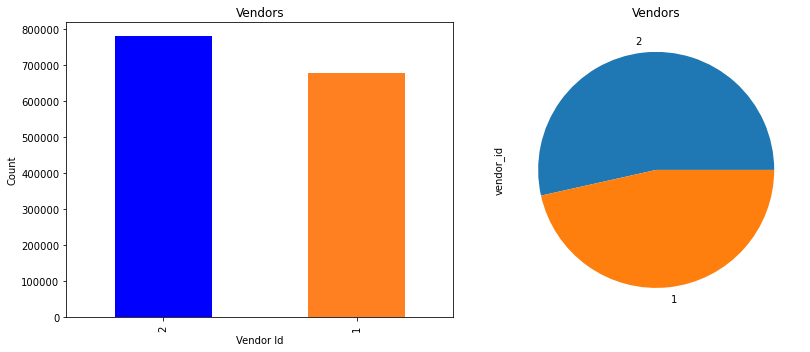

In [18]:
fig, axes = plt.subplots(nrows=1, ncols=2,figsize=(12,5))
ax = data['vendor_id'].value_counts().plot(kind='bar',title="Vendors",ax=axes[0],color = ('blue',(1, 0.5, 0.13)))
data['vendor_id'].value_counts().plot(kind='pie',title="Vendors",ax=axes[1])
ax.set_ylabel("Count")
ax.set_xlabel("Vendor Id")
fig.tight_layout()

## passenger_count

New York City Taxi Passenger Limit says:

- A maximum of 4 passengers can ride in traditional cabs.
- A child under 7 is allowed to sit on a passenger's lap in the rear seat in addition to the passenger limit.

So, in total we can assume that maximum 5 passenger can board the new york taxi i.e. 4 adult + 1 minor

In [19]:
data['passenger_count'].value_counts()

1    1033540
2     210316
5      78088
3      59896
6      48333
4      28404
0         60
7          3
9          1
8          1
Name: passenger_count, dtype: int64

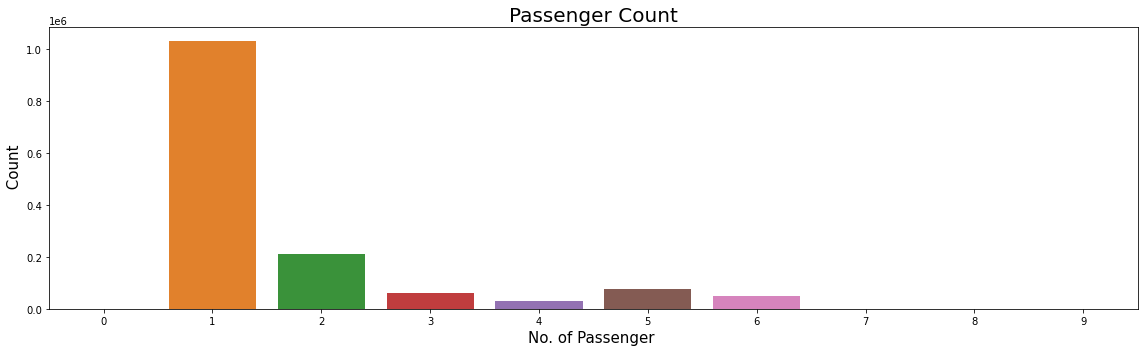

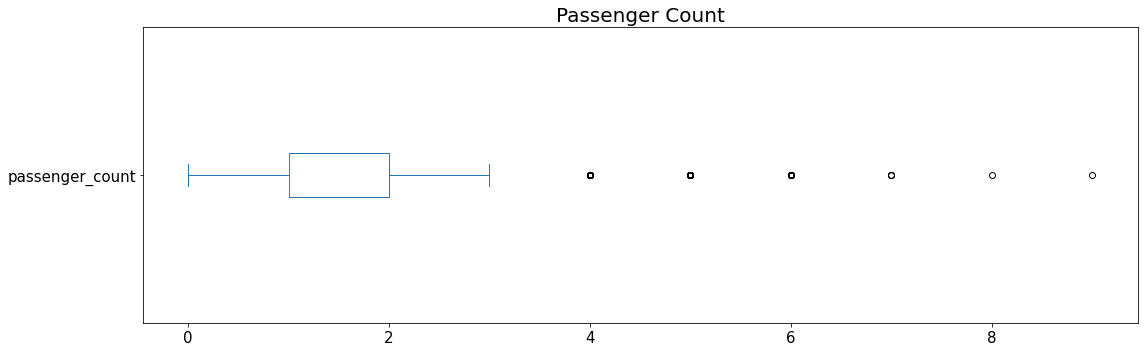

In [20]:
fig, axes = plt.subplots(nrows=1, ncols=1,figsize=(16,5))
# line = df['passenger_count'].value_counts().plot(kind='bar',fontsize = 15)
line = sns.countplot(data.passenger_count)
line.set_ylabel(" Count",fontsize = 15)
line.set_xlabel("No. of Passenger ",fontsize = 15)
line.set_title('Passenger Count',fontsize = 20)
fig.tight_layout()
fig, axes = plt.subplots(nrows=1, ncols=1,figsize=(16,5))
box = data['passenger_count'].plot(kind='box',vert = False,fontsize = 15)
box.set_title('Passenger Count',fontsize = 20)
fig.tight_layout()

- There are some trips with 0 passenger count.
- Few trips consisted of even 6, 7, 8 or 9 passengers. Clear outliers and pointers to data inconsistency
- Most of trip consist of passenger either 1 or 2.

## trip_duration

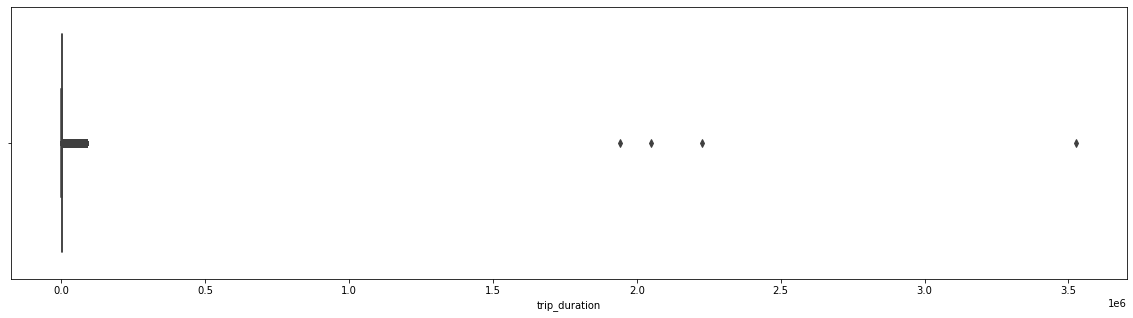

In [21]:
plt.figure(figsize = (20,5))
sns.boxplot(data.trip_duration)
plt.show()

- Some trip durations are over 100000 seconds which are clear outliers and should be removed.
- There are some durations with as low as 1 second. which points towards trips with 0 km distance.
- Major trip durations took between 10-20 mins to complete.
- Mean and mode are not same which shows that trip duration distribution is skewed towards right

Let's analyze more

In [22]:
data.trip_duration.groupby(pd.cut(data.trip_duration, np.arange(1,max(data.trip_duration),3600))).count()

trip_duration
(1, 3601]             1446311
(3601, 7201]            10045
(7201, 10801]             141
(10801, 14401]             35
(14401, 18001]              5
                       ...   
(3506401, 3510001]          0
(3510001, 3513601]          0
(3513601, 3517201]          0
(3517201, 3520801]          0
(3520801, 3524401]          0
Name: trip_duration, Length: 979, dtype: int64

- These trips ran for more than 20 days, which seems unlikely by the distance travelled.
- All the trips are taken by vendor 1 which points us to the fact that this vendor might allows much longer trip for outstations.
- All these trips are either taken on Tuesday's in 1st month or Saturday's in 2nd month. There might be some relation with the weekday, pickup location, month and the passenger.
- But they fail our purpose of correct prediction and bring inconsistencies in the algorithm calculation.

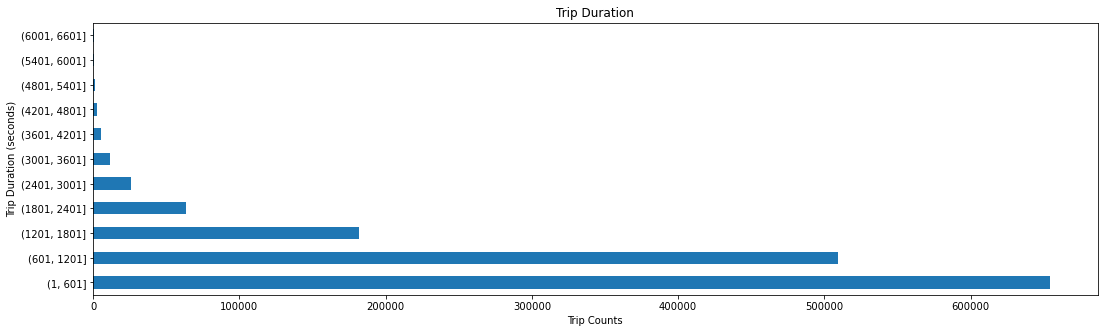

In [23]:
data.trip_duration.groupby(pd.cut(data.trip_duration, np.arange(1,7200,600))).count().plot(kind='barh',figsize = (18,5))
plt.title('Trip Duration')
plt.xlabel('Trip Counts')
plt.ylabel('Trip Duration (seconds)')
plt.show()

We can observe that most of the trips took 0 - 30 mins to complete i.e. approx 1800 secs.

## distance

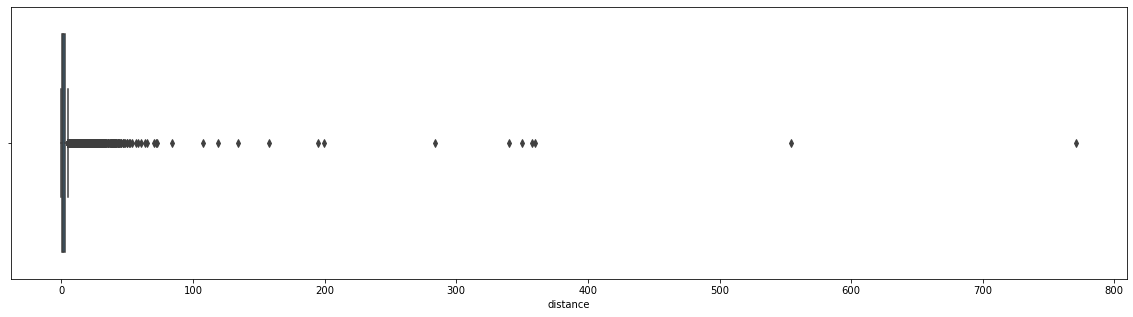

In [24]:
plt.figure(figsize = (20,5))
sns.boxplot(data.distance)
plt.show()

Interesting find:
- There some trips with over 60 miles distance.
- Some of the trips distance value is 0 miles.

In [25]:
data.distance.mean()

2.138882282287151

- mean distance travelled is approx 2.1 miles.

In [26]:
print(f"There are {data.distance[data.distance == 0 ].count()} trip records with 0 miles distance")

There are 8386 trip records with 0 miles distance


- Around 8K trip record with distance equal to 0. Below are some possible explanation for such records.
1. Customer changed mind and cancelled the journey just after accepting it.
2. Software didn't recorded dropoff location properly due to which dropoff location is the same as the pickup location.
3. Issue with GPS tracker while the journey is being finished.
4. Driver cancelled the trip just after accepting it due to some reason. So the trip couldn't start
5. Or some other issue with the software itself which a technical guy can explain

There is some serious inconsistencies in the data where drop off location is same as the pickup location. We can't think off imputing the distance values considering a correlation with the duration because the dropoff_location coordinates would not be inline with the distance otherwise. We will look more to it in bivariate analysis with the Trip duration.

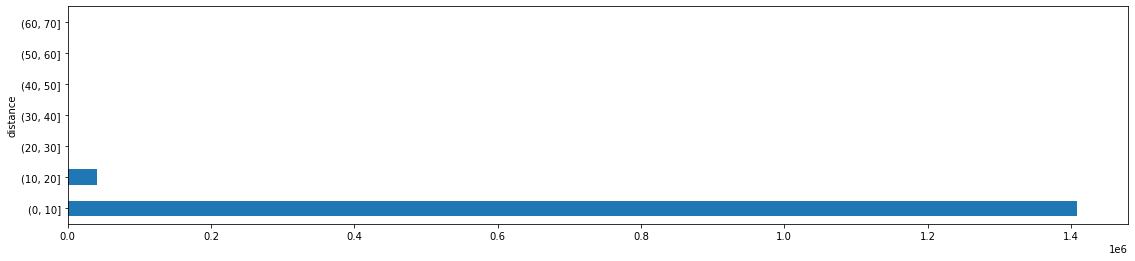

In [27]:
data.distance.groupby(pd.cut(data.distance, np.arange(0,80,10))).count().plot(kind='barh',figsize = (19,4))
plt.show()

From the above observation it is evident that most of the rides are completed between 1-10 miles with some of the rides with distances between 10-30 miles. Other slabs bar are not visible because the number of trips are very less as compared to these slabs

In [28]:
df_short = data[data.distance <= 30].count()
df_long = data[data.distance > 30].count()
print(f"Short Trips: {df_short[0]} records in total.\nLong Trips: {df_long[0]} records in total.")

Short Trips: 1458543 records in total.
Long Trips: 99 records in total.


## speed

Speed is a function of distance and time. Let's visualize speed in different trips.

Maximum speed limit in NYC is as follows:

- 25 mph in urban area
- 65 mph on controlled state highways

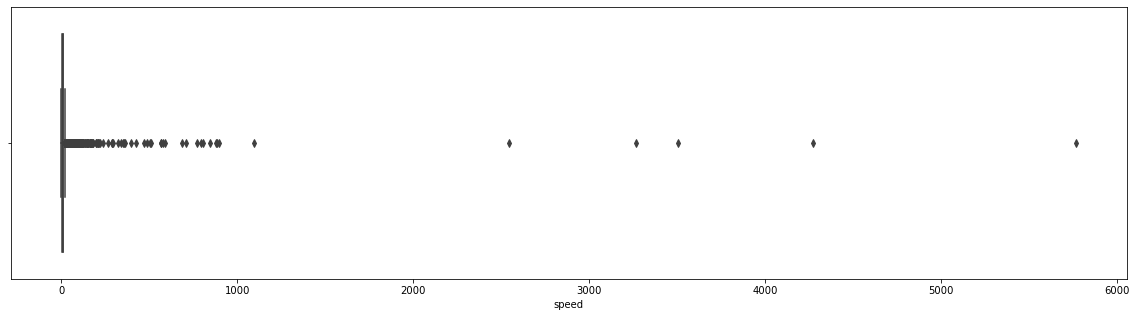

In [29]:
plt.figure(figsize = (20,5))
sns.boxplot(data.speed)
plt.show()

- Many trips were done at a speed of over 125 mile/h. Going SuperSonic..!!

Let's remove them and focus on the trips which were done at less than 65 mile/h as per the speed limits

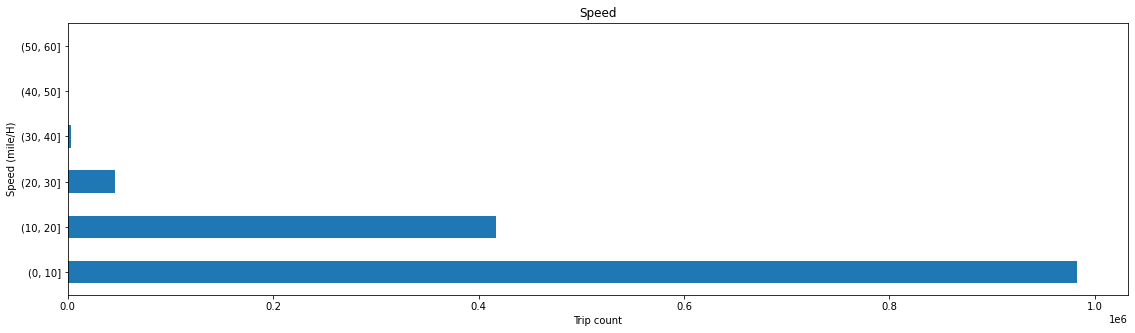

In [30]:
data.speed.groupby(pd.cut(data.speed, np.arange(0,65,10))).count().plot(kind = 'barh',figsize = (19,5))
plt.xlabel('Trip count')
plt.ylabel('Speed (mile/H)')
plt.title('Speed')
plt.show()

- Trips over 15 miles/h are being considered as outliers but we cannot ignore them because they are well under the highest speed limit of 65 mile/h on state controlled highways.
- Mostly trips are done at a speed range of 6-12 miles/h with an average speed of around 8 miles/h.

It is evident from this graph what we thought off i.e. most of the trips were done at a speed range of 6-12 miles/H.

## Total trips Per Hour

In [65]:
def clock(ax, radii, title, color):
    N = 24
    bottom = 2

    # create theta for 24 hours
    theta = np.linspace(0.0, 2 * np.pi, N, endpoint=False)

    # width of each bin on the plot
    width = (2 * np.pi) / N

    bars = ax.bar(theta, radii, width=width, bottom=bottom, color=color, edgecolor="#999999")

    # set the label go clockwise and start from the top
    ax.set_theta_zero_location("N")
    # clockwise
    ax.set_theta_direction(-1)

    # set the label
    ax.set_xticks(theta)
    ticks = ["{}:00".format(x) for x in range(24)]
    ax.set_xticklabels(ticks)
    ax.set_title(title)

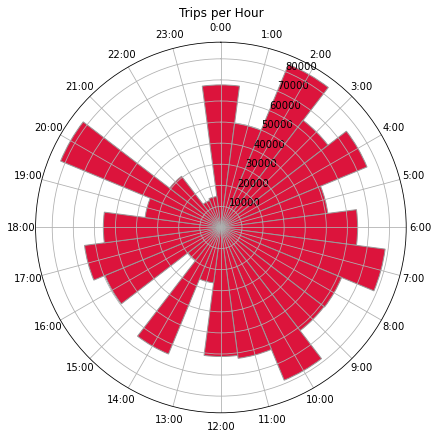

In [67]:
plt.figure(figsize=(15, 15))
ax = plt.subplot(2, 2, 1, polar=True)

# Make the histogram that bins on 24 hours
radii = np.array(df['pickup_hour'].value_counts(sort=False).tolist(), dtype="int64")
title = "Trips per Hour"
clock(ax, radii, title, "#dc143c")

In [33]:
data['pickup_hour'].value_counts()

18    90599
19    90308
21    84185
20    84072
22    80492
17    76483
14    74292
12    71873
15    71811
13    71472
23    69785
11    68476
9     67663
8     67053
10    65437
16    64313
7     55600
0     53248
1     38571
6     33248
2     27972
3     20895
4     15792
5     15002
Name: pickup_hour, dtype: int64

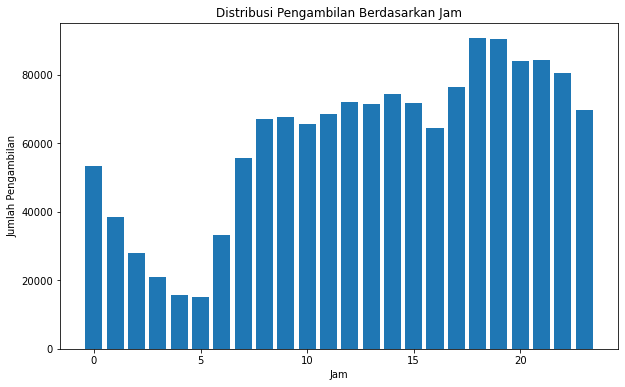

In [34]:
# Mengambil data jumlah pengambilan berdasarkan jam
pickup_hour_counts = data['pickup_hour'].value_counts()

# Menampilkan diagram jam
plt.figure(figsize=(10, 6))
plt.bar(pickup_hour_counts.index, pickup_hour_counts.values)
plt.xlabel('Jam')
plt.ylabel('Jumlah Pengambilan')
plt.title('Distribusi Pengambilan Berdasarkan Jam')
plt.show()

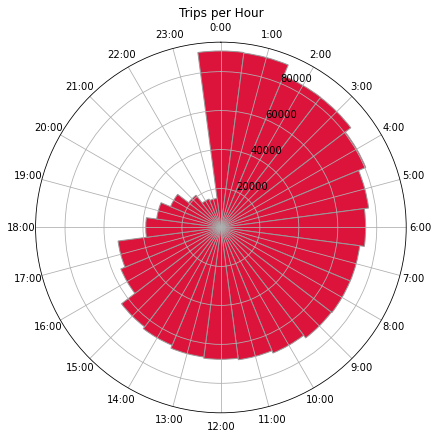

In [35]:
def clock(ax, radii, title, color):
    N = 24
    bottom = 2

    # create theta for 24 hours
    theta = np.linspace(0.0, 2 * np.pi, N, endpoint=False)

    # width of each bin on the plot
    width = (2 * np.pi) / N

    bars = ax.bar(theta, radii, width=width, bottom=bottom, color=color, edgecolor="#999999")

    # set the label go clockwise and start from the top
    ax.set_theta_zero_location("N")
    # clockwise
    ax.set_theta_direction(-1)

    # set the label
    ax.set_xticks(theta)
    ticks = ["{}:00".format(x) for x in range(24)]
    ax.set_xticklabels(ticks)
    ax.set_title(title)


# Data
df = data['pickup_hour'].value_counts()

# Plotting
plt.figure(figsize=(15, 15))
ax = plt.subplot(2, 2, 1, polar=True)

radii = np.array(df.tolist(), dtype="int64")
title = "Trips per Hour"
clock(ax, radii, title, "#dc143c")

# Show the plot
plt.show()

In [36]:
data

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration,pickup_year,pickup_month,pickup_day,pickup_hour,distance,speed
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,455,2016,3,0,17,0.93,7.358242
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,663,2016,6,6,0,1.12,6.081448
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,2124,2016,1,1,11,3.96,6.711864
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,N,429,2016,4,2,19,0.92,7.720280
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,N,435,2016,3,5,13,0.74,6.124138
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1458639,id2376096,2,2016-04-08 13:31:04,2016-04-08 13:44:02,4,-73.982201,40.745522,-73.994911,40.740170,N,778,2016,4,4,13,0.76,3.516710
1458640,id1049543,1,2016-01-10 07:35:15,2016-01-10 07:46:10,1,-74.000946,40.747379,-73.970184,40.796547,N,655,2016,1,6,7,3.76,20.665649
1458641,id2304944,2,2016-04-22 06:57:41,2016-04-22 07:10:25,1,-73.959129,40.768799,-74.004433,40.707371,N,764,2016,4,4,6,4.86,22.900524
1458642,id2714485,1,2016-01-05 15:56:26,2016-01-05 16:02:39,1,-73.982079,40.749062,-73.974632,40.757107,N,373,2016,1,1,15,0.68,6.563003


## Total trips per weekday

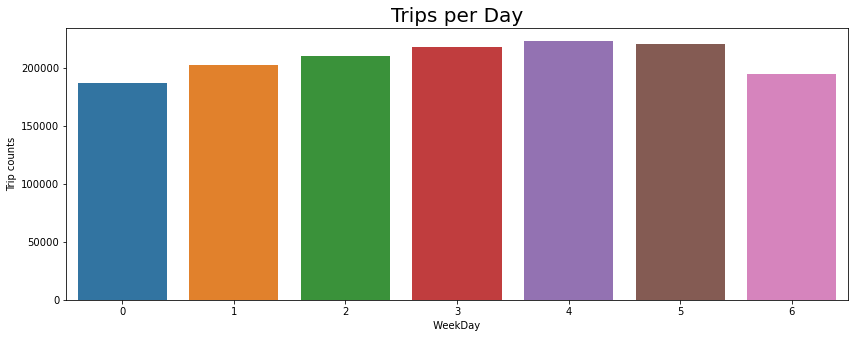

In [39]:
plt.figure(figsize = (14,5))
sns.countplot(data.pickup_day)
plt.xlabel(' WeekDay ')
plt.ylabel('Trip counts')
plt.title('Trips per Day',fontsize = 20)
plt.show()

## Trip Duration per hour

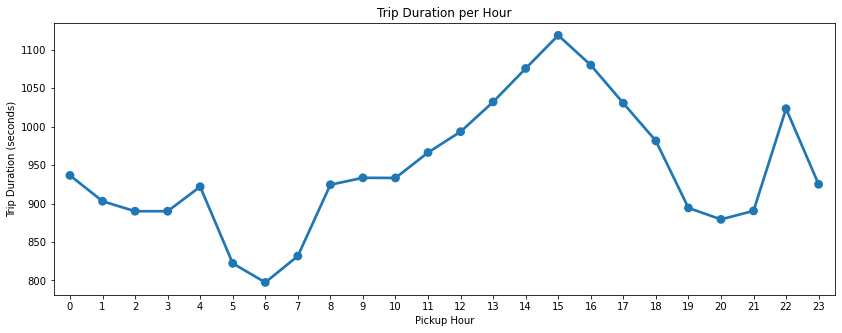

In [40]:
plt.figure(figsize = (14,5))
group1 = data.groupby('pickup_hour').trip_duration.mean()
sns.pointplot(group1.index, group1.values)
plt.ylabel('Trip Duration (seconds)')
plt.xlabel('Pickup Hour')
plt.title('Trip Duration per Hour')
plt.show()

## Trip duration per WeekDay

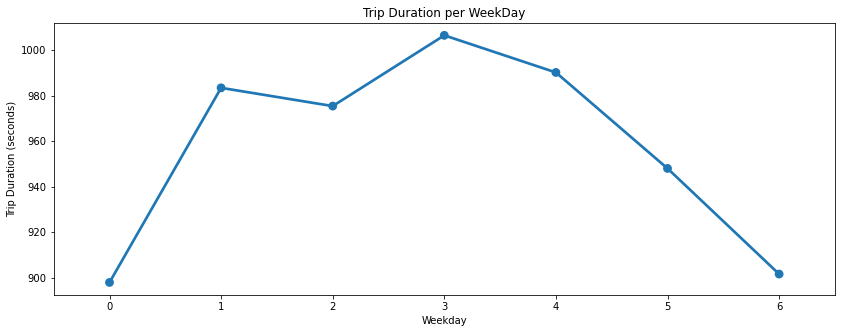

In [42]:
plt.figure(figsize = (14,5))
group2 = data.groupby('pickup_day').trip_duration.mean()
sns.pointplot(group2.index, group2.values)
plt.ylabel('Trip Duration (seconds)')
plt.xlabel('Weekday')
plt.title('Trip Duration per WeekDay')
plt.show()

## Trip duration per Month

In [43]:
data

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration,pickup_year,pickup_month,pickup_day,pickup_hour,distance,speed
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,455,2016,3,0,17,0.93,7.358242
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,663,2016,6,6,0,1.12,6.081448
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,2124,2016,1,1,11,3.96,6.711864
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,N,429,2016,4,2,19,0.92,7.720280
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,N,435,2016,3,5,13,0.74,6.124138
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1458639,id2376096,2,2016-04-08 13:31:04,2016-04-08 13:44:02,4,-73.982201,40.745522,-73.994911,40.740170,N,778,2016,4,4,13,0.76,3.516710
1458640,id1049543,1,2016-01-10 07:35:15,2016-01-10 07:46:10,1,-74.000946,40.747379,-73.970184,40.796547,N,655,2016,1,6,7,3.76,20.665649
1458641,id2304944,2,2016-04-22 06:57:41,2016-04-22 07:10:25,1,-73.959129,40.768799,-74.004433,40.707371,N,764,2016,4,4,6,4.86,22.900524
1458642,id2714485,1,2016-01-05 15:56:26,2016-01-05 16:02:39,1,-73.982079,40.749062,-73.974632,40.757107,N,373,2016,1,1,15,0.68,6.563003


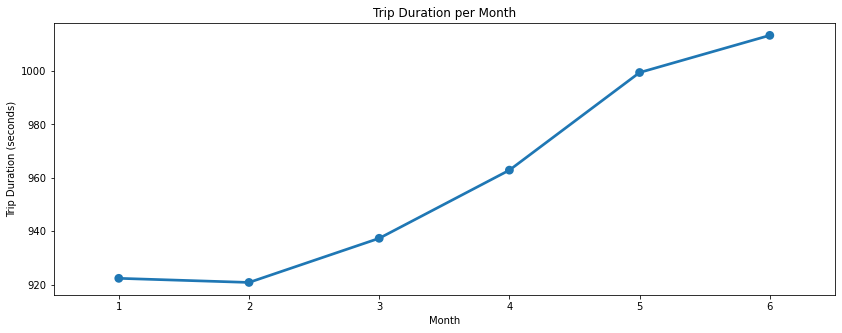

In [44]:
plt.figure(figsize = (14,5))
group3 = data.groupby('pickup_month').trip_duration.mean()
sns.pointplot(group3.index, group3.values)
plt.ylabel('Trip Duration (seconds)')
plt.xlabel('Month')
plt.title('Trip Duration per Month')
plt.show()

# MODELING

## Feature select

In [46]:
data.head(1)

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration,pickup_year,pickup_month,pickup_day,pickup_hour,distance,speed
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.96463,40.765602,N,455,2016,3,0,17,0.93,7.358242


In [47]:
df = data.drop(['id','vendor_id', 
              'pickup_datetime', 'dropoff_datetime', 
              'pickup_longitude', 'pickup_latitude', 
              'dropoff_longitude', 'dropoff_latitude', 
              'store_and_fwd_flag', 'pickup_year'],axis=1)

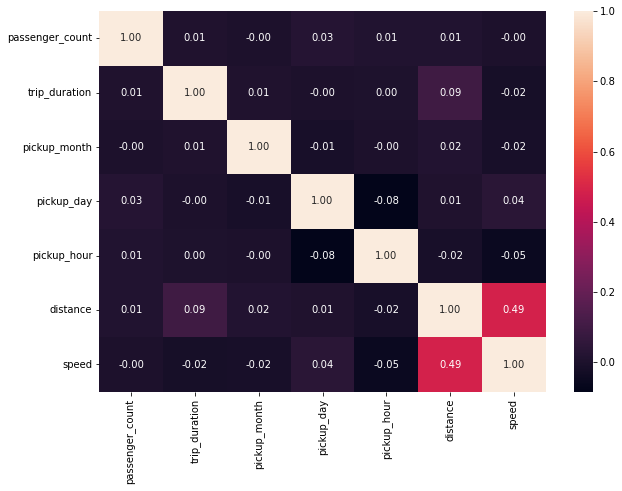

In [48]:
corr = df.corr()

plt.figure(figsize=(10,7))
sns.heatmap(corr, annot=True, fmt='.2f')
plt.show()

## Cleaning Data 

### passenger_count

In [50]:
df['passenger_count'].value_counts()

1    1033540
2     210316
5      78088
3      59896
6      48333
4      28404
0         60
7          3
9          1
8          1
Name: passenger_count, dtype: int64

delete value = 0,6,7,8,9

In [51]:
to_drop = [0, 6, 7, 8, 9]  # nilai yang akan dihapus
df = df[~df['passenger_count'].isin(to_drop)]  # menggunakan operator ~ untuk membalik hasil dari isin()

### speed

In [53]:
# Menghitung jumlah data speed yang lebih dari 65
count_speed = len(df[df['speed'] > 65])
print("Jumlah data speed lebih dari 65 MPH :", count_speed)

Jumlah data speed lebih dari 65 MPH : 150


saya memutuskan untuk menghapus data speed yang melebihi 65 MPH

In [54]:
# Menghapus data speed di atas 65
df = df[df['speed'] <= 65]

### trip_duration

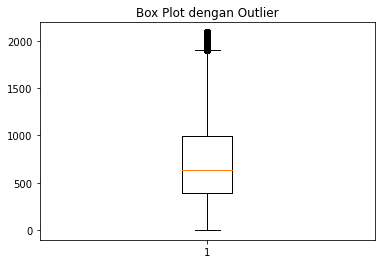

In [64]:
## TRIP DURATION
plt.boxplot(df['trip_duration'])
plt.title('Box Plot dengan Outlier')
plt.show()

In [56]:
# Menghitung nilai Q1, Q3, dan IQR
q1, q3 = np.percentile(df['trip_duration'], [25, 75])
iqr = q3 - q1

# Menentukan batas atas dan batas bawah untuk outlier
lower_bound = q1 - (1.5 * iqr)
upper_bound = q3 + (1.5 * iqr)

# Menghitung jumlah data yang dianggap sebagai outlier
outlier_count = len([x for x in df['trip_duration'] if x < lower_bound or x > upper_bound])

# Menampilkan hasil
print("Jumlah outlier:", outlier_count)

Jumlah outlier: 71686


saya memutuskan untuk menghapus outlier yang ada

In [57]:
# menghapus outlier
df = df[(df['trip_duration'] > lower_bound) & (df['trip_duration'] < upper_bound)].dropna()

### distance

In [59]:
print(f"There are {df.distance[df.distance == 0 ].count()} trip records with 0 miles distance")

There are 7936 trip records with 0 miles distance


In [60]:
# Menghapus nilai distance yang sama dengan 0
df = df[df['distance'] != 0]

In [63]:
df_short = df[df.distance <= 30].count()
df_long = df[df.distance > 30].count()
print(f"Short Trips: {df_short[0]} records in total.\nLong Trips: {df_long[0]} records in total.")

Short Trips: 1330374 records in total.
Long Trips: 0 records in total.


## ML 

In [68]:
# split train test
from sklearn.model_selection import train_test_split

X = df.drop(columns='trip_duration')
y = df[['trip_duration']] # target yang mau di ramal

# First splitting: pretrain and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

In [70]:
import time

### Decision Tree

In [71]:
start_time = time.time()
dt_regression = DecisionTreeRegressor()
dt_regression = dt_regression.fit(X_train, y_train)
end_time = time.time()
dt_time = (end_time - start_time)
print(f"Time taken to train Decision tree model : {dt_time} seconds")

Time taken to train Decision tree model : 6.616703510284424 seconds


In [72]:
trips = dt_regression.predict(X_test)

In [73]:
predictions = pd.DataFrame({'Actual': y_test.values.flatten(), 'Predicted': trips.flatten()})

In [74]:
predictions

,Actual,Predicted
0,148,148.0
1,660,654.0
2,239,239.0
3,749,749.0
4,1000,1000.0
...,...,...
266070,833,833.0
266071,984,983.0
266072,380,380.0
266073,1269,1270.0


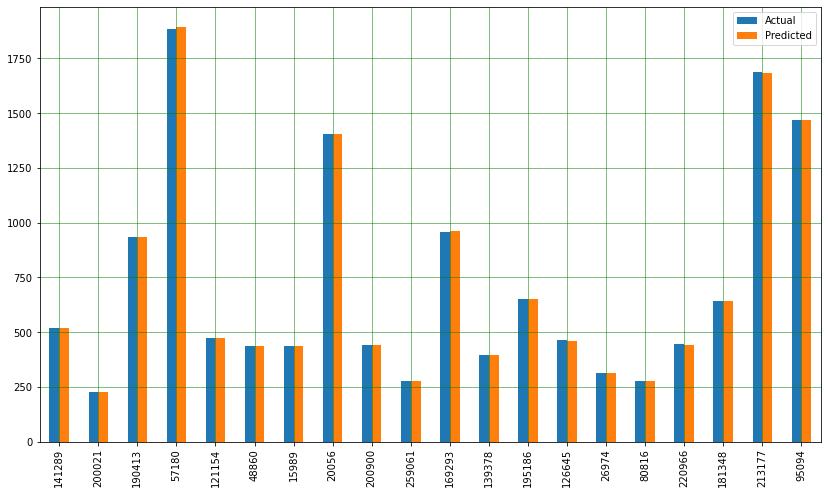

In [75]:
predictions.sample(20).plot(kind='bar',figsize=(14,8))
plt.grid(which='major', linestyle='-', linewidth='0.5', color='green')
plt.grid(which='minor', linestyle=':', linewidth='0.5', color='black')
plt.show()

In [76]:
dt_score = r2_score(y_test, trips)
print(dt_score)

0.9999235935154075


In [124]:
mse = mean_squared_error(y_test, trips)
rmse_dt = np.sqrt(mse)

print("RMSE:", rmse_dt)

RMSE: 13.215708108409864


### Rendom Forest

In [78]:
start_time = time.time()
rf_regression = RandomForestRegressor()
rf_regression = rf_regression.fit(X_train, y_train)
end_time = time.time()
rf_time = (end_time - start_time)
print(f"Time taken to train Random Forest model : {rf_time} seconds")

Time taken to train Random Forest model : 418.69582653045654 seconds


In [82]:
trips = rf_regression.predict(X_test)

In [83]:
predictions = pd.DataFrame({'Actual': y_test.values.flatten(), 'Predicted': trips.flatten()})

In [84]:
predictions

,Actual,Predicted
0,148,148.00
1,660,661.62
2,239,239.00
3,749,748.97
4,1000,1000.07
...,...,...
266070,833,833.01
266071,984,983.96
266072,380,380.04
266073,1269,1269.87


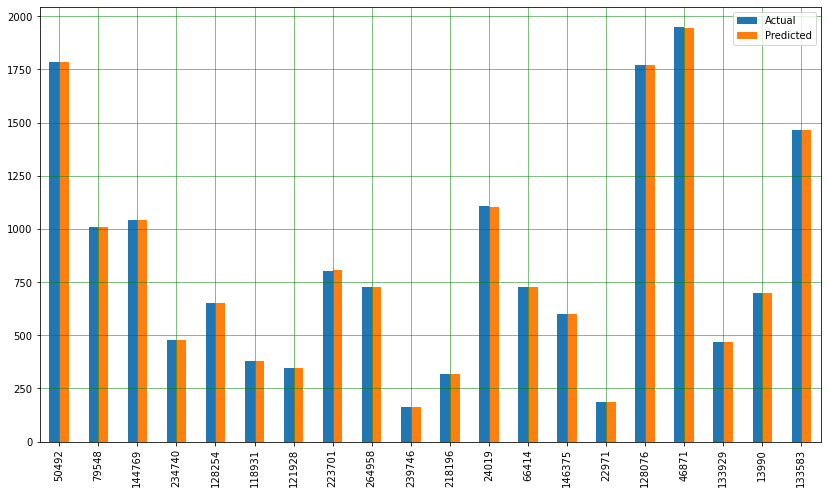

In [85]:
predictions.sample(20).plot(kind='bar',figsize=(14,8))
plt.grid(which='major', linestyle='-', linewidth='0.5', color='green')
plt.grid(which='minor', linestyle=':', linewidth='0.5', color='black')
plt.show()

In [86]:
rf_score = r2_score(y_test, trips)
print(rf_score)

0.9999864273761214


In [122]:
mse = mean_squared_error(y_test, trips)
rmse_rf = np.sqrt(mse)

print("RMSE:", rmse_rf)

RMSE: 13.215708108409864


### Ada Boost

In [88]:
start_time = time.time()
regression = AdaBoostRegressor()
regression = regression.fit(X_train, y_train)
end_time = time.time()
ad_time = (end_time - start_time)
print(f"Time taken to train AdaBoost model : {ad_time} seconds")

Time taken to train AdaBoost model : 102.40730881690979 seconds


In [89]:
trips = regression.predict(X_test)

In [90]:
predictions = pd.DataFrame({'Actual': y_test.values.flatten(), 'Predicted': trips.flatten()})

In [91]:
predictions

,Actual,Predicted
0,148,360.941364
1,660,894.793194
2,239,466.537084
3,749,939.618424
4,1000,1079.980169
...,...,...
266070,833,987.255604
266071,984,1079.980169
266072,380,513.876106
266073,1269,1353.592826


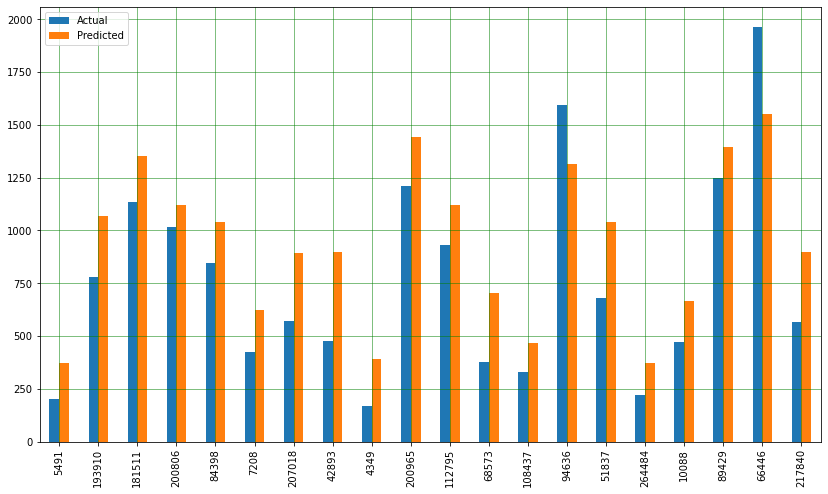

In [92]:
predictions.sample(20).plot(kind='bar',figsize=(14,8))
plt.grid(which='major', linestyle='-', linewidth='0.5', color='green')
plt.grid(which='minor', linestyle=':', linewidth='0.5', color='black')
plt.show()

In [93]:
ad_score = r2_score(y_test, trips)
print(ad_score)

0.6707774777359081


In [123]:
mse = mean_squared_error(y_test, trips)
rmse_ad = np.sqrt(mse)

print("RMSE:", rmse_ad)

RMSE: 13.215708108409864


### Gradient Boost

In [96]:
start_time = time.time()
regression = GradientBoostingRegressor()
regression = regression.fit(X_train, y_train)
end_time = time.time()
gd_time = (end_time - start_time)
print(f"Time taken to train Gradient Boost model : {gd_time} seconds")

Time taken to train Gradient Boost model : 137.51580142974854 seconds


In [97]:
trips = regression.predict(X_test)

In [98]:
predictions = pd.DataFrame({'Actual': y_test.values.flatten(), 'Predicted': trips.flatten()})

In [99]:
predictions

,Actual,Predicted
0,148,151.716172
1,660,746.972696
2,239,250.180980
3,749,738.086943
4,1000,1007.432023
...,...,...
266070,833,849.347107
266071,984,979.527300
266072,380,379.864473
266073,1269,1274.335794


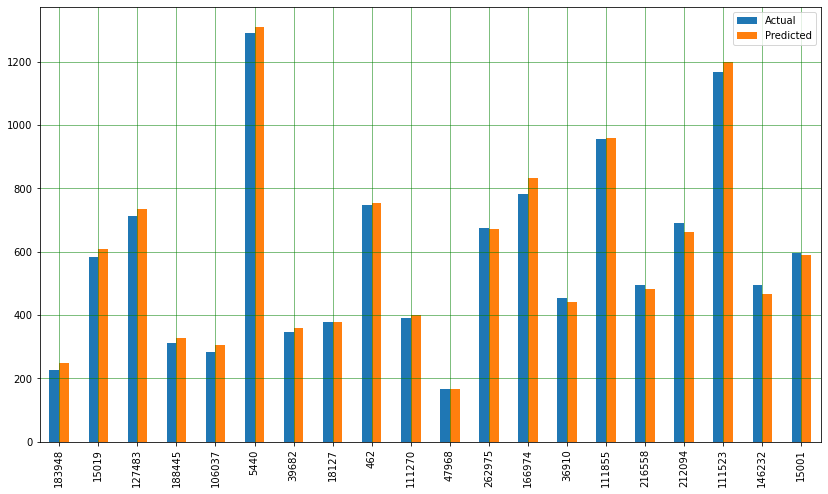

In [100]:
predictions.sample(20).plot(kind='bar',figsize=(14,8))
plt.grid(which='major', linestyle='-', linewidth='0.5', color='green')
plt.grid(which='minor', linestyle=':', linewidth='0.5', color='black')
plt.show()

In [101]:
gd_score = r2_score(y_test, trips)
print(gd_score)

0.9916637763217222


In [102]:
mse = mean_squared_error(y_test, trips)
rmse_gb = np.sqrt(mse)

print("RMSE:", rmse_gb)

RMSE: 40.801267246225876


### XGBoost

In [103]:
start_time = time.time()
regression = XGBRegressor(objective ='reg:squarederror')
regression = regression.fit(X_train, y_train)
end_time = time.time()
xgb_time = (end_time - start_time)
print(f"Time taken to train XGBoost  model : {xgb_time} seconds")

Time taken to train XGBoost  model : 45.216283082962036 seconds


In [104]:
trips = regression.predict(X_test)

In [105]:
predictions = pd.DataFrame({'Actual': y_test.values.flatten(), 'Predicted': trips.flatten()})

In [106]:
predictions

,Actual,Predicted
0,148,155.192505
1,660,656.484680
2,239,235.259796
3,749,748.271851
4,1000,987.806580
...,...,...
266070,833,829.413940
266071,984,967.097473
266072,380,380.390564
266073,1269,1249.658813


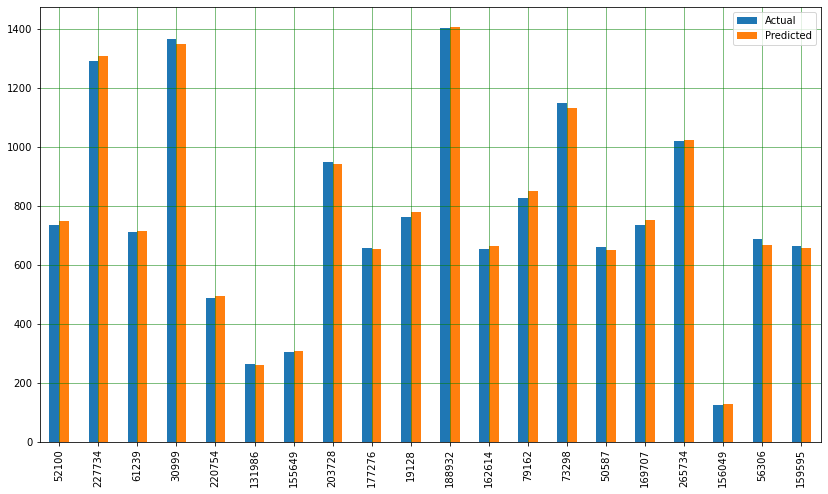

In [107]:
predictions.sample(20).plot(kind='bar',figsize=(14,8))
plt.grid(which='major', linestyle='-', linewidth='0.5', color='green')
plt.grid(which='minor', linestyle=':', linewidth='0.5', color='black')
plt.show()

In [108]:
xgb_score = r2_score(y_test, trips)
print(xgb_score)

0.9991254131746076


In [109]:
mse = mean_squared_error(y_test, trips)
rmse_xgb = np.sqrt(mse)

print("RMSE:", rmse_xgb)

RMSE: 13.215708108409864


## Model Comparation 

In [116]:
r2 = [dt_score, rf_score, ad_score, gd_score, xgb_score]
tm = [dt_time, rf_time, ad_time, gd_time, xgb_time]
rmse = [rmse_dt, rmse_rf, rmse_ad, rmse_gb, rmse_xgb]
comp = pd.DataFrame({'Time': tm, 'Accu': r2, 'Error' : rmse})

In [121]:
rmse_rf

256.4092813121551

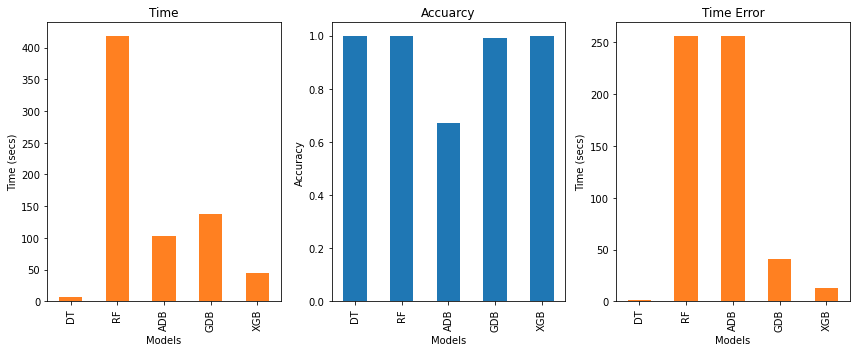

In [125]:
label = ['DT', 'RF', 'ADB', 'GDB', 'XGB']
fig, axes = plt.subplots(nrows=1, ncols=3,figsize=(12,5))
ax = comp['Time'].plot(kind='bar',title="Time",ax=axes[0],color = (1, 0.5, 0.13))
ax1 = comp['Accu'].plot(kind='bar',title="Accuarcy",ax=axes[1])
ax2 = comp['Error'].plot(kind='bar',title="Time Error",ax=axes[2],color = (1, 0.5, 0.13))
ax.set_ylabel("Time (secs)")
ax.set_xlabel('Models')
ax.set_xticklabels(label)
ax1.set_ylabel("Accuracy")
ax1.set_xlabel('Models')
ax1.set_xticklabels(label)
ax2.set_ylabel("Time (secs)")
ax2.set_xlabel('Models')
ax2.set_xticklabels(label)
fig.tight_layout()